<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-functions,-packages-and-data" data-toc-modified-id="Loading-functions,-packages-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading functions, packages and data</a></span></li><li><span><a href="#Regressing-backward-beta" data-toc-modified-id="Regressing-backward-beta-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regressing backward beta</a></span><ul class="toc-item"><li><span><a href="#Sorting-banks-into-3-groups-according-to-backward-betas" data-toc-modified-id="Sorting-banks-into-3-groups-according-to-backward-betas-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Sorting banks into 3 groups according to backward betas</a></span></li><li><span><a href="#Assigning-weights-and-calculate-average-values-for-each-timestep-(value-weighted)" data-toc-modified-id="Assigning-weights-and-calculate-average-values-for-each-timestep-(value-weighted)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Assigning weights and calculate average values for each timestep (value-weighted)</a></span></li></ul></li><li><span><a href="#Tabel-with-summuraized-statistics" data-toc-modified-id="Tabel-with-summuraized-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Tabel with summuraized statistics</a></span></li><li><span><a href="#Plot-value-weighted-equity-ratio-and-Tier-1-ratio" data-toc-modified-id="Plot-value-weighted-equity-ratio-and-Tier-1-ratio-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot value-weighted equity ratio and Tier 1 ratio</a></span></li></ul></div>

## Loading functions, packages and data

In [1]:
def geomean(data):
    
    n = data.shape[0]
    
    
    return (data+1).prod()**(1/n)-1

In [5]:
"""
Beta function for rolling backward beta
"""

def market_beta(X,Y,min_win,max_win):
    """ 
    X = The independent variable which is the Market
    Y = The dependent variable which is the Stock
    min_win = minimum length of the window
    max_win = maximum length of the window
    
    It returns the alphas and the betas of
    the rolling regression
    """
    
    # all the observations
    obs = len(X)
    
    # initiate the betas with null values
    betas = np.full(obs, np.nan)
    
    # initiate the alphas with null values
    alphas = np.full(obs, np.nan)
    
    # initiate the MSE with null values
    MSE = np.full(obs, np.nan)
    
    
    regressor = LinearRegression()
    for i in range(min_win,obs,1):
        if i <= max_win: #to get the expanding window
            if np.isnan(Y.to_numpy()[1 : i+1]).sum() > 0: #if missing values in the window then pass
                pass
            else:
                regressor.fit(X.to_numpy()[1 : i+1].reshape(-1,1), Y.to_numpy()[1: i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
                MSE[i] = mean_squared_error(Y.to_numpy()[1: i+1],regressor.predict(X.to_numpy()[1 : i+1].reshape(-1,1)))
        else: #the rolling window when periode = max window
            if np.isnan(Y.to_numpy()[i-max_win : i+1]).sum() > 0:
                pass
            else:
                regressor.fit(X.to_numpy()[i-max_win : i+1].reshape(-1,1), Y.to_numpy()[i-max_win : i+1])
                betas[i]  = regressor.coef_[0]
                alphas[i]  = regressor.intercept_
                MSE[i] = mean_squared_error(Y.to_numpy()[i-max_win : i+1],regressor.predict(X.to_numpy()[i-max_win : i+1].reshape(-1,1)))                            
        
    return pd.DataFrame({'Alpha': alphas, 'Beta': betas, 'MSE': MSE})
 

In [2]:
%load_ext autoreload
%autoreload 2

"""
Load relevant packages 
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import pandas_datareader as pdr
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pickle
from scipy.stats import kurtosis
from scipy.stats import skew
from typing import Union, List
import math as m
from sklearn import datasets, linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [3]:
"""
Set path to get save data
"""
path = "/Users/julielaustsen/Desktop/OneDrive/UNI/Speciale /Data/Eikon"
os.chdir(path) 

In [4]:
"""
Load saved dataframes and dictionareis
"""
with open('df_mkt', 'rb') as data_market_df:
    df_mkt = pickle.load(data_market_df)
    
with open('df_rf', 'rb') as data_riskfree_df:
    df_rf = pickle.load(data_riskfree_df)

with open('data_calc', 'rb') as data_dict_calc:
    data_calc = pickle.load(data_dict_calc)  
    
with open('data_calc_win', 'rb') as data_dict_win:
    data_calc_win = pickle.load(data_dict_win) 
    
with open('dict_sort', 'rb') as data_sort_list:
    dict_sort = pickle.load(data_sort_list) 

## Regressing backward beta
This file only contains backward beta values

In [6]:
"""
Apply the market backward beta function on data
"""
regress_calc = {}

for i in data_calc_win.keys():
    regress_calc[i] = market_beta(df_mkt['EUROPE IM (excess)'],data_calc_win[i].iloc[:,2], 12, 24) #set minimum and max window here
    regress_calc[i].set_index(data_calc_win[i].index)

In [7]:
"""
We drop the first 12 observations because we know they wil be nan
"""
for i in data_calc_win.keys():
    regress_calc[i] = regress_calc[i].drop([0,1,2,3,4,5,6,7,8,9,10,11])

### Sorting banks into 3 groups according to backward betas

In [8]:
"""
To have a dataframe with all the backward betas
"""
beta = pd.concat([regress_calc[i].Beta for i in list(regress_calc.keys())], axis=1)
beta.columns = list(regress_calc.keys())

In [9]:
"""
To create a dictionary for each portfolio group that contains a list for each timestep with the names of the banks in that group.
"""
low_group, middle_group, high_group = {},{},{}
no_obs_beta = beta.shape[0]

for i in range(no_obs_beta):
        no_betas = beta.iloc[i,:].count()
        no_low, no_middle = m.floor(no_betas*0.3), m.floor(no_betas*0.4) #low bottom = 30% and top bottom = 30% see BW
        no_high = no_betas - (no_low + no_middle)
        low_group[i]=list(beta.iloc[i,:].sort_values()[:no_low].index)
        middle_group[i]=list(beta.iloc[i,:].sort_values()[no_low:no_low+no_middle].index)
        high_group[i]=list(beta.iloc[i,:].sort_values()[no_low + no_middle:no_betas].index)

In [10]:
"""
We create a dictionary for the low beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

low_group_calc = {}

for i in low_group.keys():
    df = pd.DataFrame(columns=low_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = regress_calc[j].iloc[i,2].copy() #MSE
        s4 = data_calc_win[j].iloc[i,0].copy() #market value
        s5 = data_calc_win[j].iloc[i,2].copy() #excess return
        s6 = data_calc_win[j].iloc[i,5].copy() #Book Equity ratio
        s7 = data_calc_win[j].iloc[i,7].copy() #Tier 1 ratio
        df[j] = [s1,s2,s3,s4,s5,s6,s7]
    low_group_calc[i] = df.T
    low_group_calc[i].columns = ['Alpha', 'Beta', 'MSE', 'Market value', 'Excess return','Book Equity ratio', 'Tier 1 ratio']

In [11]:
"""
We create a dictionary for the middle beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

middle_group_calc = {}

for i in middle_group.keys():
    df = pd.DataFrame(columns=middle_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = regress_calc[j].iloc[i,2].copy() #MSE
        s4 = data_calc_win[j].iloc[i,0].copy() #market value
        s5 = data_calc_win[j].iloc[i,2].copy() #excess return
        s6 = data_calc_win[j].iloc[i,5].copy() #Book Equity ratio
        s7 = data_calc_win[j].iloc[i,7].copy() #Tier 1 ratio
        df[j] = [s1,s2,s3,s4,s5,s6,s7]
    middle_group_calc[i] = df.T
    middle_group_calc[i].columns = ['Alpha', 'Beta', 'MSE', 'Market value', 'Excess return','Book Equity ratio', 'Tier 1 ratio']

In [12]:
"""
We create a dictionary for the high beta group containing a dataframe for each timestep with the banks', within
the group, alpha, beta, market value, and excess return
"""

high_group_calc = {}

for i in high_group.keys():
    df = pd.DataFrame(columns=high_group[i])
    for j in df.columns:
        s1 = regress_calc[j].iloc[i,0].copy() #alpha
        s2 = regress_calc[j].iloc[i,1].copy() #beta
        s3 = regress_calc[j].iloc[i,2].copy() #MSE
        s4 = data_calc_win[j].iloc[i,0].copy() #market value
        s5 = data_calc_win[j].iloc[i,2].copy() #excess return
        s6 = data_calc_win[j].iloc[i,5].copy() #Book Equity ratio
        s7 = data_calc_win[j].iloc[i,7].copy() #Tier 1 ratio
        df[j] = [s1,s2,s3,s4,s5,s6,s7]
    high_group_calc[i] = df.T
    high_group_calc[i].columns = ['Alpha', 'Beta', 'MSE', 'Market value', 'Excess return', 'Book Equity ratio', 'Tier 1 ratio']

### Assigning weights and calculate average values for each timestep (value-weighted)

In [13]:
"""
Assigning weights based on market value
"""

for i in low_group_calc.keys():
    low_group_calc[i]['weight'] = low_group_calc[i].iloc[:,3]/(low_group_calc[i]['Market value'].sum())

for i in middle_group_calc.keys():
    middle_group_calc[i]['weight'] = middle_group_calc[i].iloc[:,3]/(middle_group_calc[i]['Market value'].sum())
    
for i in high_group_calc.keys():
    high_group_calc[i]['weight'] = high_group_calc[i].iloc[:,3]/(high_group_calc[i]['Market value'].sum())

In [14]:
"""
Create equal weighted and value weighted for the low beta group
"""

low_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'ew_MSE', 'vw_excess_ret','vw_beta', 'vw_alpha', 'vw_MSE'])

for i in low_group_calc.keys():
    low_val.loc[i,'ew_excess_ret'] = (low_group_calc[i]['Excess return']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'ew_beta'] = (low_group_calc[i]['Beta']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'ew_alpha'] = (low_group_calc[i]['Alpha']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'ew_MSE'] = (low_group_calc[i]['MSE']*(1/len(low_group[i]))).sum()
    low_val.loc[i,'vw_excess_ret'] = (low_group_calc[i]['Excess return']*low_group_calc[i]['weight']).sum()
    low_val.loc[i,'vw_beta'] = (low_group_calc[i]['Beta']*low_group_calc[i]['weight']).sum()
    low_val.loc[i,'vw_alpha'] = (low_group_calc[i]['Alpha']*low_group_calc[i]['weight']).sum()
    low_val.loc[i,'vw_MSE'] = (low_group_calc[i]['MSE']*low_group_calc[i]['weight']).sum()

In [15]:
"""
Create equal weighted and value weighted for the middle beta group
"""

middle_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'ew_MSE', 'vw_excess_ret','vw_beta', 'vw_alpha', 'vw_MSE'])

for i in middle_group_calc.keys():
    middle_val.loc[i,'ew_excess_ret'] = (middle_group_calc[i]['Excess return']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'ew_beta'] = (middle_group_calc[i]['Beta']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'ew_alpha'] = (middle_group_calc[i]['Alpha']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'ew_MSE'] = (middle_group_calc[i]['MSE']*(1/len(middle_group[i]))).sum()
    middle_val.loc[i,'vw_excess_ret'] = (middle_group_calc[i]['Excess return']*middle_group_calc[i]['weight']).sum()
    middle_val.loc[i,'vw_beta'] = (middle_group_calc[i]['Beta']*middle_group_calc[i]['weight']).sum()
    middle_val.loc[i,'vw_alpha'] = (middle_group_calc[i]['Alpha']*middle_group_calc[i]['weight']).sum()
    middle_val.loc[i,'vw_MSE'] = (middle_group_calc[i]['MSE']*middle_group_calc[i]['weight']).sum()

In [16]:
"""
Create equal weighted and value weighted for the high beta group
"""

high_val = pd.DataFrame(columns=['ew_excess_ret', 'ew_beta', 'ew_alpha', 'vw_excess_ret','vw_beta', 'vw_alpha'])

for i in high_group_calc.keys():
    high_val.loc[i,'ew_excess_ret'] = (high_group_calc[i]['Excess return']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'ew_beta'] = (high_group_calc[i]['Beta']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'ew_alpha'] = (high_group_calc[i]['Alpha']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'ew_MSE'] = (high_group_calc[i]['MSE']*(1/len(high_group[i]))).sum()
    high_val.loc[i,'vw_excess_ret'] = (high_group_calc[i]['Excess return']*high_group_calc[i]['weight']).sum()
    high_val.loc[i,'vw_beta'] = (high_group_calc[i]['Beta']*high_group_calc[i]['weight']).sum()
    high_val.loc[i,'vw_alpha'] = (high_group_calc[i]['Alpha']*high_group_calc[i]['weight']).sum()
    high_val.loc[i,'vw_MSE'] = (high_group_calc[i]['MSE']*high_group_calc[i]['weight']).sum()

## Tabel with summuraized statistics

In [17]:
"""
Tabel 2 - MEANS
"""
Tabel2 = pd.DataFrame(columns=['Bottom (EW)', 'Bottom (VW)', 'Middle (EW)', 'Middle (VW)', 'Top (EW)', 'Top (VW)'])

Tabel2.loc['Beta','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_beta'].mean())
Tabel2.loc['Beta','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_beta'].mean())
Tabel2.loc['Beta','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_beta'].mean())
Tabel2.loc['Beta','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_beta'].mean())
Tabel2.loc['Beta','Top (EW)'] = '{:,.03f}'.format(high_val['ew_beta'].mean())
Tabel2.loc['Beta','Top (VW)'] = '{:,.03f}'.format(high_val['vw_beta'].mean())

Tabel2.loc['MSE','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_MSE'].mean())
Tabel2.loc['MSE','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_MSE'].mean())
Tabel2.loc['MSE','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_MSE'].mean())
Tabel2.loc['MSE','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_MSE'].mean())
Tabel2.loc['MSE','Top (EW)'] = '{:,.03f}'.format(high_val['ew_MSE'].mean())
Tabel2.loc['MSE','Top (VW)'] = '{:,.03f}'.format(high_val['vw_MSE'].mean())

Tabel2.loc['Excess return','Bottom (EW)'] = '{:,.03f}'.format(geomean(low_val['ew_excess_ret']))
Tabel2.loc['Excess return','Bottom (VW)'] = '{:,.03f}'.format(geomean(low_val['vw_excess_ret']))
Tabel2.loc['Excess return','Middle (EW)'] = '{:,.03f}'.format(geomean(middle_val['ew_excess_ret']))
Tabel2.loc['Excess return','Middle (VW)'] = '{:,.03f}'.format(geomean(middle_val['vw_excess_ret']))
Tabel2.loc['Excess return','Top (EW)'] = '{:,.03f}'.format(geomean(high_val['ew_excess_ret']))
Tabel2.loc['Excess return','Top (VW)'] = '{:,.03f}'.format(geomean(high_val['vw_excess_ret']))

Tabel2.loc['Alpha','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_alpha'].mean())
Tabel2.loc['Alpha','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_alpha'].mean())
Tabel2.loc['Alpha','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_alpha'].mean())
Tabel2.loc['Alpha','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_alpha'].mean())
Tabel2.loc['Alpha','Top (EW)'] = '{:,.03f}'.format(high_val['ew_alpha'].mean())
Tabel2.loc['Alpha','Top (VW)'] = '{:,.03f}'.format(high_val['vw_alpha'].mean())

Tabel2.loc['No. obs','Bottom (EW)'] = '{:,.0f}'.format(np.sum([len(low_group[i]) for i in low_group.keys()]))
Tabel2.loc['No. obs','Bottom (VW)'] = '{:,.0f}'.format(np.sum([len(low_group[i]) for i in low_group.keys()]))
Tabel2.loc['No. obs','Middle (EW)'] = '{:,.0f}'.format(np.sum([len(middle_group[i]) for i in middle_group.keys()]))
Tabel2.loc['No. obs','Middle (VW)'] = '{:,.0f}'.format(np.sum([len(middle_group[i]) for i in middle_group.keys()]))
Tabel2.loc['No. obs','Top (EW)'] = '{:,.0f}'.format(np.sum([len(high_group[i]) for i in high_group.keys()]))
Tabel2.loc['No. obs','Top (VW)'] = '{:,.0f}'.format(np.sum([len(high_group[i]) for i in high_group.keys()]))

In [18]:
"""
Tabel 2 - MEDIAN
"""
Tabel2_median = pd.DataFrame(columns=['Bottom (EW)', 'Bottom (VW)', 'Middle (EW)', 'Middle (VW)', 'Top (EW)', 'Top (VW)'])

Tabel2_median.loc['Beta','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_beta'].median())
Tabel2_median.loc['Beta','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_beta'].median())
Tabel2_median.loc['Beta','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_beta'].median())
Tabel2_median.loc['Beta','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_beta'].median())
Tabel2_median.loc['Beta','Top (EW)'] = '{:,.03f}'.format(high_val['ew_beta'].median())
Tabel2_median.loc['Beta','Top (VW)'] = '{:,.03f}'.format(high_val['vw_beta'].median())

Tabel2_median.loc['MSE','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_MSE'].median())
Tabel2_median.loc['MSE','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_MSE'].median())
Tabel2_median.loc['MSE','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_MSE'].median())
Tabel2_median.loc['MSE','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_MSE'].median())
Tabel2_median.loc['MSE','Top (EW)'] = '{:,.03f}'.format(high_val['ew_MSE'].median())
Tabel2_median.loc['MSE','Top (VW)'] = '{:,.03f}'.format(high_val['vw_MSE'].median())

Tabel2_median.loc['Excess return','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_excess_ret'].median())
Tabel2_median.loc['Excess return','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_excess_ret'].median())
Tabel2_median.loc['Excess return','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_excess_ret'].median())
Tabel2_median.loc['Excess return','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_excess_ret'].median())
Tabel2_median.loc['Excess return','Top (EW)'] = '{:,.03f}'.format(high_val['ew_excess_ret'].median())
Tabel2_median.loc['Excess return','Top (VW)'] = '{:,.03f}'.format(high_val['vw_excess_ret'].median())

Tabel2_median.loc['Alpha','Bottom (EW)'] = '{:,.03f}'.format(low_val['ew_alpha'].median())
Tabel2_median.loc['Alpha','Bottom (VW)'] = '{:,.03f}'.format(low_val['vw_alpha'].median())
Tabel2_median.loc['Alpha','Middle (EW)'] = '{:,.03f}'.format(middle_val['ew_alpha'].median())
Tabel2_median.loc['Alpha','Middle (VW)'] = '{:,.03f}'.format(middle_val['vw_alpha'].median())
Tabel2_median.loc['Alpha','Top (EW)'] = '{:,.03f}'.format(high_val['ew_alpha'].median())
Tabel2_median.loc['Alpha','Top (VW)'] = '{:,.03f}'.format(high_val['vw_alpha'].median())

Tabel2_median.loc['No. obs','Bottom (EW)'] = '{:,.0f}'.format(np.sum([len(low_group[i]) for i in low_group.keys()]))
Tabel2_median.loc['No. obs','Bottom (VW)'] = '{:,.0f}'.format(np.sum([len(low_group[i]) for i in low_group.keys()]))
Tabel2_median.loc['No. obs','Middle (EW)'] = '{:,.0f}'.format(np.sum([len(middle_group[i]) for i in middle_group.keys()]))
Tabel2_median.loc['No. obs','Middle (VW)'] = '{:,.0f}'.format(np.sum([len(middle_group[i]) for i in middle_group.keys()]))
Tabel2_median.loc['No. obs','Top (EW)'] = '{:,.0f}'.format(np.sum([len(high_group[i]) for i in high_group.keys()]))
Tabel2_median.loc['No. obs','Top (VW)'] = '{:,.0f}'.format(np.sum([len(high_group[i]) for i in high_group.keys()]))

In [19]:
"""
Displays mean values
"""
Tabel2

,Bottom (EW),Bottom (VW),Middle (EW),Middle (VW),Top (EW),Top (VW)
Beta,0.038,0.019,0.679,0.817,1.717,1.675
MSE,0.004,0.005,0.006,0.006,0.013,0.010
Excess return,-0.002,-0.002,-0.006,-0.005,-0.027,-0.018
Alpha,-0.000,-0.003,-0.005,-0.006,-0.019,-0.013
No. obs,"11,288","11,288","15,095","15,095","11,615","11,615"


In [20]:
"""
Display median values
"""
Tabel2_median

,Bottom (EW),Bottom (VW),Middle (EW),Middle (VW),Top (EW),Top (VW)
Beta,0.008,0.005,0.653,0.747,1.723,1.674
MSE,0.003,0.003,0.005,0.005,0.012,0.007
Excess return,0.001,0.001,0.005,0.005,-0.000,0.004
Alpha,0.001,-0.000,-0.004,-0.006,-0.020,-0.012
No. obs,"11,288","11,288","15,095","15,095","11,615","11,615"


## Plot value-weighted equity ratio and Tier 1 ratio

In [21]:
tier_low = np.full(len(low_group_calc.keys()), np.nan)
equity_low = np.full(len(low_group_calc.keys()), np.nan)

for i in low_group_calc.keys():
    tier_low[i] = np.mean(low_group_calc[i]['Tier 1 ratio'])
    equity_low[i] = np.mean(low_group_calc[i]['Book Equity ratio'])
    
tier_mid = np.full(len(middle_group_calc.keys()), np.nan)
equity_mid = np.full(len(middle_group_calc.keys()), np.nan)

for i in middle_group_calc.keys():
    tier_mid[i] = np.mean(middle_group_calc[i]['Tier 1 ratio'])
    equity_mid[i] = np.mean(middle_group_calc[i]['Book Equity ratio'])
    
tier_high = np.full(len(high_group_calc.keys()), np.nan)
equity_high = np.full(len(high_group_calc.keys()), np.nan)

for i in high_group_calc.keys():
    tier_high[i] = np.mean(high_group_calc[i]['Tier 1 ratio'])
    equity_high[i] = np.mean(high_group_calc[i]['Book Equity ratio'])

In [22]:
time = data_calc_win['HSBC HOLDINGS'].index

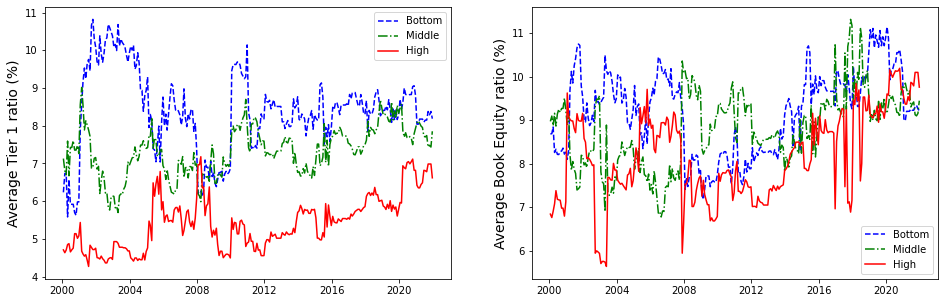

In [34]:
"""
Plotting the results - Tier 1 ratio
"""
fig, ax = plt.subplots(1, 2,figsize=(16,5))
ax[0].plot(time[12:], tier_low*100, color='blue', label='Bottom', linestyle='--')
ax[0].plot(time[12:], tier_mid*100, color='green', label='Middle', linestyle='-.')
ax[0].plot(time[12:], tier_high*100, color='red', label='High', linestyle='-')
ax[0].set_ylabel('Average Tier 1 ratio (%)').set_fontsize(14)
ax[0].legend();

ax[1].plot(time[12:], equity_low*100, color='blue', label='Bottom', linestyle='--')
ax[1].plot(time[12:], equity_mid*100, color='green', label='Middle', linestyle='-.')
ax[1].plot(time[12:], equity_high*100, color='red', label='High', linestyle='-')
ax[1].set_ylabel('Average Book Equity ratio (%)').set_fontsize(14)
ax[1].legend();